# Excercise project 4 LSTM for time series forecasting
### **Step 0:** Importing necessary libraries

In [214]:
#pip install ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


### **Step 1:** Reading dataset
For this excecise, I chose a gold market dataset to predict how the exchange rate went.

In [215]:
df = pd.read_csv("gld_price_data.csv")
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


### **Step 2:** Cleanup
There are no missing values, and there is a gap on every weekend. But because the stock market is closed on weekends, I don't consider these as "gaps", as the data is sequential and there is no change to the exchange rates on Saturday and Sunday. I cut off the beginning of the dataset to avoid using too old data.

In [216]:
df = df.iloc[800:]

Checking for null values:

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 800 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1490 non-null   object 
 1   SPX      1490 non-null   float64
 2   GLD      1490 non-null   float64
 3   USO      1490 non-null   float64
 4   SLV      1490 non-null   float64
 5   EUR/USD  1490 non-null   float64
dtypes: float64(5), object(1)
memory usage: 70.0+ KB


Describing numeric columns

In [218]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000
mean,1934.452926,130.108278,23.689823,20.247130,1.222741
std,414.999266,19.595190,11.647756,6.318954,0.107433
min,1099.229980,100.500000,7.960000,13.060000,1.039047
25%,1587.804992,117.110001,11.442500,15.660000,1.119047
50%,1989.414978,123.369999,20.520001,17.335000,1.232544
75%,2163.727478,139.892502,34.950001,23.115001,1.319993
max,2872.870117,182.899994,42.009998,41.220001,1.443314


My value column that I try to predict will be **GLD**. I apply MinMaxScaler on it.

In [219]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

value_column = "GLD" 

Scaling values with `MinMaxScaler()`

In [220]:
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])


df = df[[value_column]]
df.head()

,GLD
800,0.953884
801,0.937136
802,0.938956
803,1.000000
804,0.929369


### **Step 3:** Split
For the train/test/validation split, I chose 60/20/20% proportion and used the modern Tensorflow Datasets.

In [221]:
cutoff = int(len(df) * 0.6)
cutoff2 = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

#validation data
X_val = df.index[cutoff:cutoff2]
y_val = df[value_column].iloc[cutoff:cutoff2]

# test data
X_test = df.index[cutoff2:]
y_test = df[value_column].iloc[cutoff2:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))
val_series = y_val.reshape((len(y_val), n_features))


The split visualized:

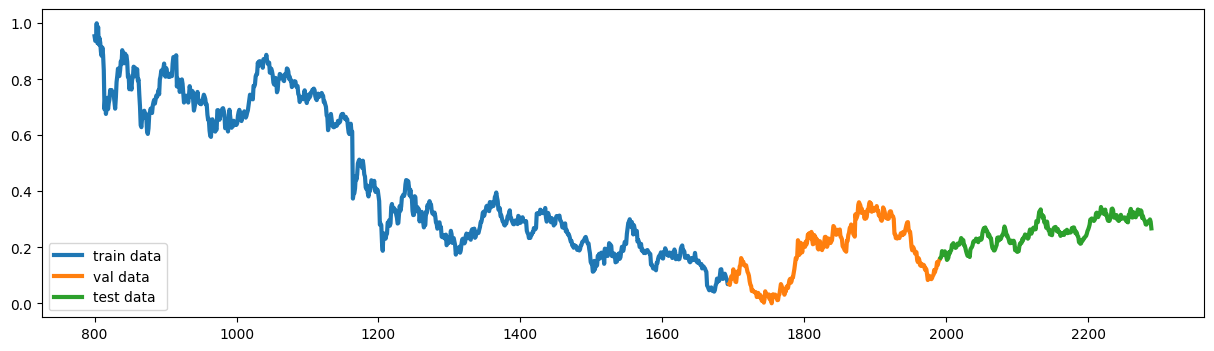

In [222]:

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_val,y_val, lw=3, label='val data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

Using Tensorflow Datasets

In [223]:
from tensorflow.keras.utils import timeseries_dataset_from_array

look_back  = 30
batch_size = 10

train_generator = timeseries_dataset_from_array(
    data=train_series,
    targets=train_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = timeseries_dataset_from_array(
    data=test_series,
    targets=test_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False,
)

val_generator = timeseries_dataset_from_array(
    data=val_series,
    targets=val_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False,
)

### **Step 4:** Building neural network
For this excercise I am trying an LSTM to see a long term prediction. I also tried a simple RNN but LSTM worked out a bit better for this dataset. I am also using ModelCheckpoint and EarlyStopping for better results.

In [224]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint('best_model_gld.keras', monitor='val_loss', mode='min', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

callback_list = [mc, early_stop]


n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    callbacks=callback_list
)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0534 - val_loss: 0.0030
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0534 - val_loss: 0.0030
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0124 - val_loss: 0.0026
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0124 - val_loss: 0.0026
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0107 - val_loss: 0.0020
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0107 - val_loss: 0.0020
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0089 - val_loss: 0.0017
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0089 - val_loss: 0.0017
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0074

Training visualization:

<Axes: >

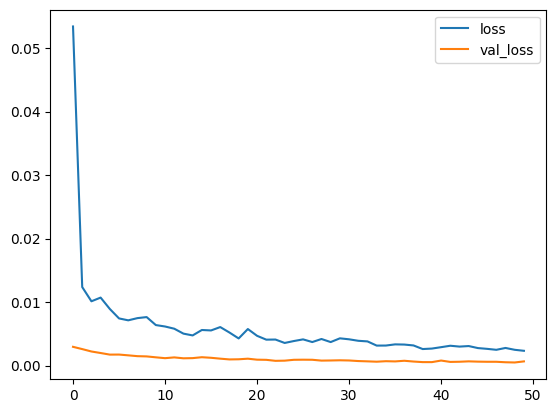

In [225]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

Loading best model

In [226]:
from keras.models import load_model
model = load_model("best_model_gld.keras")

Training and testing loss:

In [227]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039
Training loss: 0.003879136871546507
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.6239e-04Training loss: 0.003879136871546507
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6422e-04
Testing loss: 0.00036421907134354115
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6422e-04
Testing loss: 0.00036421907134354115


In [228]:
test_predictions  = model.predict(test_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


### **Step 5:** Metrics
MAE, MSE, RMSE, R2, MAPE:


In [229]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
5.89 %

MAE
0.02 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.79


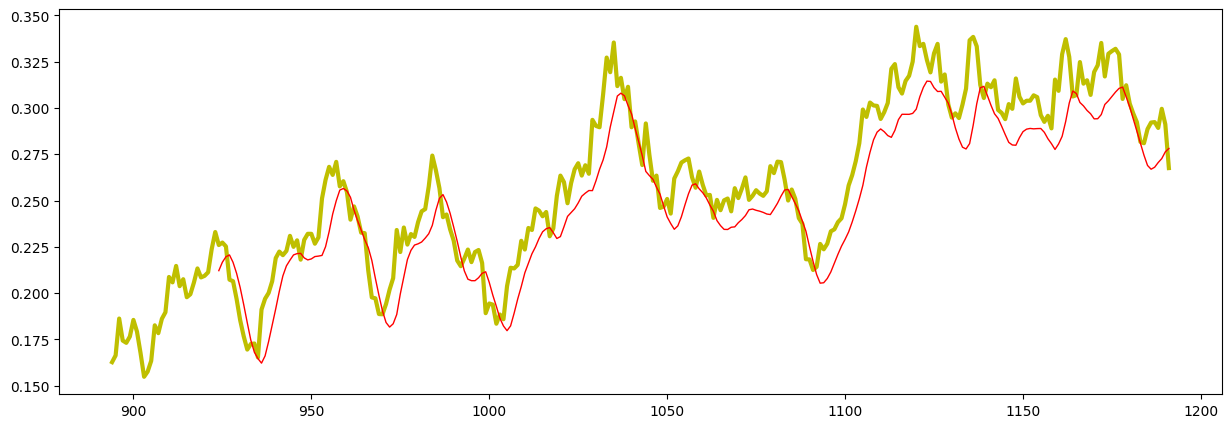

In [230]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
plt.show()

### **Step 6:** Extrapolation
Trying the model to predict future. I create 500 new points to see how well the model predicts.

In [231]:
extrapolation = []
seed_batch = test_series[:look_back].reshape((1, look_back, n_features))
current_batch = seed_batch.copy()

for i in range(500):
    pred = model.predict(current_batch, verbose=0)
    predicted_value = float(pred[0, 0])
    extrapolation.append(predicted_value)
    new_val = np.array(predicted_value).reshape(1, 1, n_features)
    current_batch = np.concatenate([current_batch[:, 1:, :], new_val], axis=1)

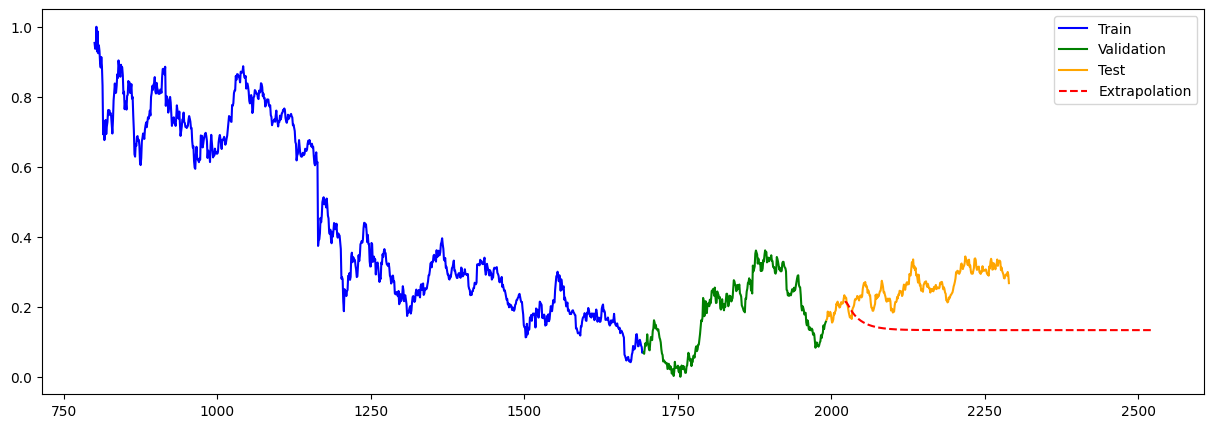

In [232]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

step = X_test[1] - X_test[0]  # 0.5

extrapolation_arr = np.squeeze(np.array(extrapolation))


start_x = X_test[look_back] if look_back < len(X_test) else X_test[-1]
extrap_x = np.arange(start_x, start_x + len(extrapolation_arr) * step, step)

plt.figure(figsize=(15,5))
plt.plot(X_train, y_train, label='Train', color='blue')
plt.plot(X_val, y_val, label='Validation', color='green')
plt.plot(X_test, y_test, label='Test', color='orange')
plt.plot(extrap_x, extrapolation_arr, label='Extrapolation', color='red', linestyle='--')
plt.legend()
plt.show()

### **Step 8:** Conclusion
Unfortunately, the extrapolation part didn't really work out for me. I tried many things, using RNN and LSTM, changing neural network structure, changing look back size, with and without validation, changing train/test/validation sizes, changing number of epochs, etc. Maybe there is something I overlooked, but I couldn't get the model to work better then what is visible here.